# MDS를 활용한 화학 분자의 시각화
#### 제작 : 허종국 (hjkso1406@korea.ac.kr)

뇌혈관장벽 투과성, 용해도, 전기음성도 등 화학 분자의 물성을 예측하는 것은 화학 정보학 분야에서 가장 중요한 태스크 중 하나입니다.
이러한 물성은 화학 분자가 가진 작용기나 구조적 특징(Scaffold)에 의해 주로 결정됩니다.
이번 튜토리얼은 PubChem이라는 1000만개의 unlabeled data에서 분자를 공통된 Scaffold에 따라 임의로 레이블링 한 뒤, MDS를 통해 Scaffold에 해당하는 분자들이 어떻게 분포하고 있는지에 대해 알아보도록 하겠습니다.
* Caution : 해당 튜토리얼을 진행하기에 앞서 rdkit 패키지를 설치해주세요! 참고로 rdkit package는 python 3.8 이상부터는 에러가 나므로 3.7 환경에서 하는 것을 권장 드립니다.
* 본 튜토리얼에서 사용한 이미지는 고려대학교 강필성 교수님의 대학원 강의인 Business Analytics 강의 자료에서 첨부하였음을 알립니다.

In [1]:
## 패키지 로딩
from utils import read_pubchem_smiles, generate_scaffolds, molecular_distance
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from multiprocessing import Pool

random.seed(777)
np.random.seed(777)


## Multidimensional Scaling

각 분자에 따른 거리를 2차원 행렬로 계산한 후에 아래 함수를 통해 저차원으로 임베딩할 것입니다.
MDS의 단계는 다음과 같습니다.

- 1. 거리 행렬 D를 구한다.
- 2. 거리 행렬 D로부터 행렬 A를 구한다.
- 3. 행렬 A로부터 x좌표의 내적값으로 이루어진 행렬 B를 유추한다.
- 4. 행렬 B의 고윳값 분해를 통해 좌표 행렬 X를 구한다.

    - Input : $$ Distance Matrix (D)$$
    - Ouput : $$ Coordinates (X)$$
    <img src='./images/fig1-1.png' width='800'></img>

In [2]:
def multidimensional_scaling(distance_matrix: np.array):
    assert distance_matrix.shape[0] == distance_matrix.shape[1]
    
    n = distance_matrix.shape[0]
    
    A = -0.5 * np.power(distance_matrix, 2)
    H = np.identity(n) - np.ones((n, n), dtype=float)/n
    B = H @ A @ H
    
    p = np.linalg.matrix_rank(B)
    e_lambda, e_v= np.linalg.eig(B)
    
    X = e_v[:, :p] @ np.diag(np.sqrt(e_lambda[:p]))
    return X

## Load SMILES from PubChem 10M Dataset
본 튜토리얼에서 사용하는 PubDhem Dataset은 약 10M개의 텍스트로 구성되어 있습니다.
각 텍스트는 화학 분자를 일련의 문자열로 표기하는 SMILES 표기 규칙으로 작성되어 있습니다.
각 분자에 따른 시각화와 그에 따른 SMILES 표기는 아래 예시와 같습니다.

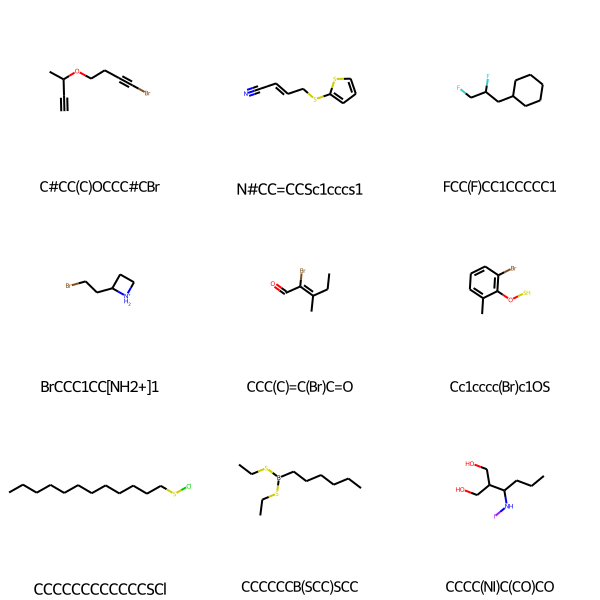

In [3]:
## Draw Sample Molecules
smiles = read_pubchem_smiles('./data/pubchem-10m-clean.txt')

sample_smiles = random.sample(sorted(smiles, key=lambda x: len(x))[10000:15000],9)
sample_mols = [Chem.MolFromSmiles(m) for m in sample_smiles]
Draw.MolsToGridImage(sample_mols, legends=sample_smiles)

## Generate Scaffolds with PubChem Data
- Scaffold 는 분자를 이루는 큰 뼈대를 뜻합니다. Scaffold 혹은 작용기 등 구조가 비슷한 분자는 비슷한 물성을 가지고 있을 확률이 높습니다.
- 따라서 각 분자별로 Scaffold를 추출하고 공통된 Scaffold에 속한 분자들을 같은 Class로 정의하겠습니다.
- PubChem의 데이터 개수가 너무 많은 관계로 약 2만개의 분자만을 가지고 실습을 진행하겠습니다.

In [5]:
## 분자별로 Scaffold를 추출하고 Scaffold에 따라 어떠한 분자가 속해있는지 Dictionary를 통해 구축합니다.

total_scaffold_sets = generate_scaffolds(smiles[:20000])

Total Data Size 20000, about to generate scaffolds
Generating scaffold 0/20000
Generating scaffold 1000/20000
Generating scaffold 2000/20000
Generating scaffold 3000/20000
Generating scaffold 4000/20000
Generating scaffold 5000/20000
Generating scaffold 6000/20000
Generating scaffold 7000/20000
Generating scaffold 8000/20000
Generating scaffold 9000/20000
Generating scaffold 10000/20000
Generating scaffold 11000/20000
Generating scaffold 12000/20000
Generating scaffold 13000/20000
Generating scaffold 14000/20000
Generating scaffold 15000/20000
Generating scaffold 16000/20000
Generating scaffold 17000/20000
Generating scaffold 18000/20000
Generating scaffold 19000/20000


## Draw Molecules with Same Scaffolds

아래 그림은 Scaffold 2, 7, 77, 82, 100번에 대해 속해있는 분자들의 예시입니다.
- 각 행의 첫번째 그림은 Scaffold, 두번째에서 네번째 그림은 해당 Scaffold를 가지고 있는 분자들입니다.

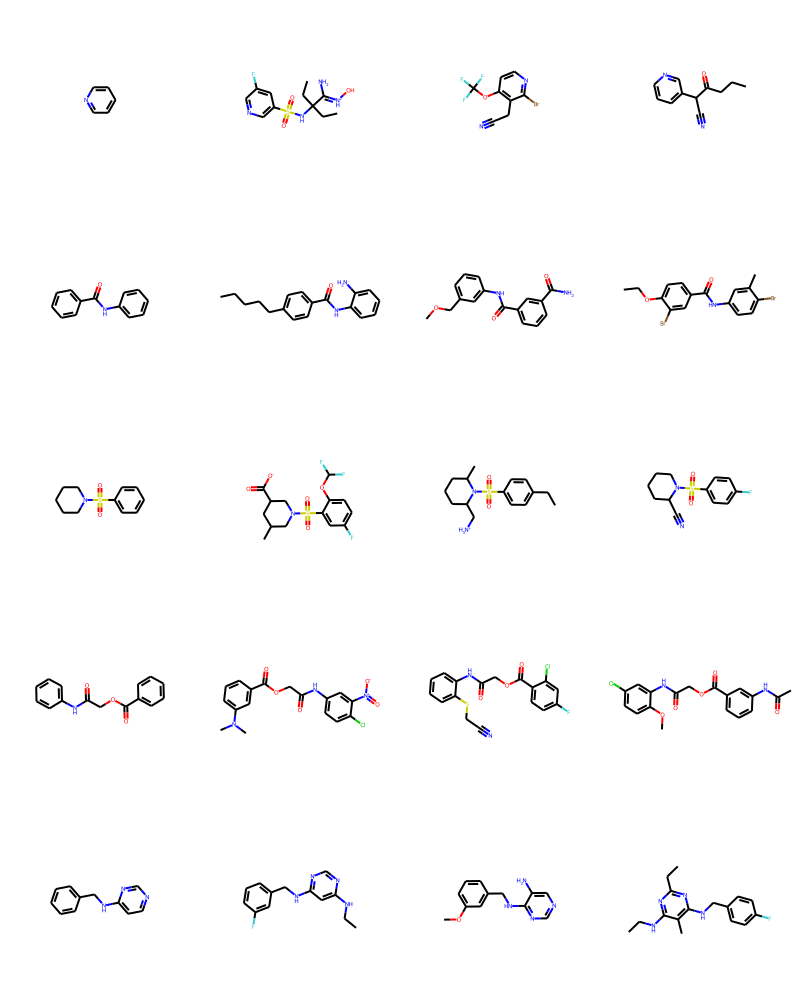

In [22]:
scaffold_sets = [(scaffold, list(map(lambda i: smiles[i], indices))) for scaffold, indices in list(map(lambda i: total_scaffold_sets[i], [2, 7, 77, 82, 100]))]


scaffold_samples = list(itertools.chain(*[(k, *v[:3]) for k, v in scaffold_sets]))
scaffold_samples = [Chem.MolFromSmiles(m) for m in scaffold_samples]
Draw.MolsToGridImage(scaffold_samples, molsPerRow=4)

## Calculate Distance Matrix
본 튜토리얼에서 분자간의 거리를 계산하기 위해 분자간의 유사도를 계산합니다. 분자 간의 유사도는 Tanimoto Similarity를 통해 구하고
1에서 유사도를 뺀 dissimilarity를 거리라고 정의하겠습니다.

In [23]:
indices = list(itertools.chain(*[[idx] * len(molecules) for idx, (scaffold, molecules) in enumerate(scaffold_sets)]))
molecules = list(itertools.chain(*[molecules for scaffold, molecules in scaffold_sets]))
molecules = [Chem.MolFromSmiles(m) for m in molecules]

combination = [(a, b) for a, b in list(itertools.product(molecules, molecules))]
with Pool(8) as p:
    distance_matrix = p.starmap(molecular_distance, combination)
distance_matrix = np.array(distance_matrix).reshape(len(molecules), -1)

분자를 2차원으로 시각화하기 위해 MDS에서 추출한 X좌표에서 2차원까지만 사용합니다.

In [24]:
coordinate_matrix = multidimensional_scaling(distance_matrix)
coordinates = coordinate_matrix[:,:2]

c:\Users\korea\anaconda3\envs\BA_chapter1\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


2번(빨간색)과 4번(파란색) Scaffold를 가진 분자들이 MDS 상에서 유사하게 표시되는 것을 알 수 있습니다.
2번과 4번 Scaffold는 두 개의 벤젠 고리 사이에 카보닐기를 공유하고 있다는 특징이 있으므로 두 Scaffold가 비슷하다고 추정하는것은 타당하다고 할 수 있습니다. 카보닐기는 산소와 이중 결합으로 이루어진 탄소가 두 개의 알킬기(탄소와 수소로 구성된 부분)으로 이루어진 작용기입니다.
- 벤젠과 카보닐기는 아래 그림과 같습니다.
    <img src='./images/fig1-2.png' width='800'></img>

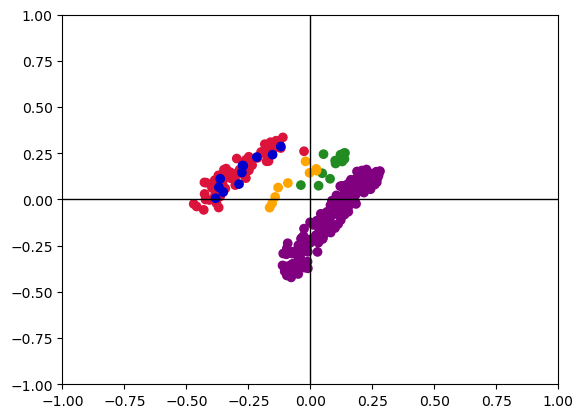

In [25]:
scaffold_colors = ['purple', 'crimson', 'forestgreen', 'mediumblue', 'orange']

colors = [scaffold_colors[idx] for idx in indices]
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
plt.show()